# Import and misc

In [ ]:
# Instal latest torch and torchaudio

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In [2]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-05 12:22:25--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.164.176, 2607:f8b0:4004:815::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.164.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   190MB/s    in 6.4s    

2022-11-05 12:22:32 (220 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [4]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [5]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [6]:
dataset.csv.sample(5)

,path,keyword,label
18462,speech_commands/seven/01bb6a2a_nohash_3.wav,seven,0
21742,speech_commands/one/70a00e98_nohash_3.wav,one,0
17361,speech_commands/four/324210dd_nohash_3.wav,four,0
63688,speech_commands/zero/035de8fe_nohash_0.wav,zero,0
29549,speech_commands/nine/742d6431_nohash_2.wav,nine,0


### Augmentations

In [7]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [8]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [9]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [10]:
train_set[0]

{'wav': tensor([ 0.0036,  0.0070,  0.0147,  ..., -0.0006, -0.0228, -0.0144]),
 'keywors': 'left',
 'label': 0}

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [20]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [21]:
tconfig = TaskConfig()
teacher = torch.load('teacher_model.pth', map_location=tconfig.device)
teacher.eval()

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

## StudentConfig

In [115]:
# Уменьшаем параметры у студента
# После решетки указаны старые параметры

@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3 # 3e-4
    weight_decay: float = 1e-5 # 1e-5
    num_epochs: int = 40 # 20
    n_mels: int = 40
    cnn_out_channels: int = 2 # 8
    kernel_size: Tuple[int, int] = (5, 20) # (5, 20)
    stride: Tuple[int, int] = (2, 8) # (2, 8)
    hidden_size: int = 22 # 64
    gru_num_layers: int = 1 # 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    T: float = 10
    a: float = 0.6


sconfig = StudentConfig()
student = CRNN(sconfig).to(sconfig.device)

In [116]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

In [117]:
sopt = torch.optim.Adam(
    student.parameters(),
    lr=sconfig.learning_rate,
    weight_decay=sconfig.weight_decay
)

# Student training

In [109]:
import random

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [110]:
import time

class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose
        self.total_time = 0

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t
        self.total_time += self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [119]:
def dkd_train_epoch(teacher, student, opt, loader, log_melspec, device, T, a):
    student.train()
    teacher.eval()
    scaler = torch.cuda.amp.GradScaler()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            logits_student = student(batch)
            with torch.no_grad():
                logits_teacher = teacher(batch)

        # distillation loss + student loss
        with torch.cuda.amp.autocast():
            probs_student = F.log_softmax(logits_student / T, dim=-1)
            probs_teacher = F.log_softmax(logits_teacher / T, dim=-1)
  
            probs = F.softmax(logits_student.to(float), dim=-1)
        
            loss = nn.KLDivLoss()(probs_student, probs_teacher) * (T ** 2) * a + F.cross_entropy(logits_student, labels) * (1 - a)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        scaler.step(opt)
        scaler.update()
        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [122]:
@torch.no_grad()
def dkd_validation(teacher, student, loader, log_melspec, device, T, a):
    student.eval()
    teacher.eval()
    #scaler = torch.cuda.amp.GradScaler()
    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        with torch.cuda.amp.autocast():
            logits_student = student(batch.half())
            logits_teacher = teacher(batch)

            # distillation loss + student loss
            probs_student = F.log_softmax(logits_student / T, dim=-1)
            probs_teacher = F.log_softmax(logits_teacher / T, dim=-1)
            probs = F.softmax(logits_student.to(float), dim=-1)
            
            loss = nn.KLDivLoss()(probs_student, probs_teacher) * (T ** 2) * a + F.cross_entropy(logits_student, labels) * (1 - a)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

Student | Elapsed time : 877.95


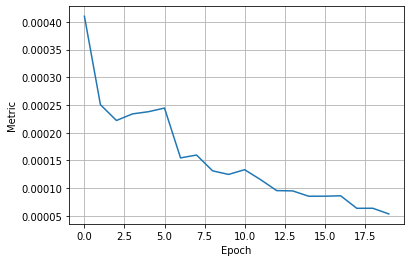

END OF EPOCH 19
The student reached the baseline


In [123]:
# TRAIN
seed_all(112)

timer = Timer('student')
for n in range(StudentConfig.num_epochs):
    with timer:
        dkd_train_epoch(teacher, student, sopt, train_loader, melspec_train, sconfig.device, sconfig.T, sconfig.a)

        au_fa_fr = dkd_validation(teacher, student, val_loader,
                          melspec_val, sconfig.device, sconfig.T, sconfig.a)
        history['val_metric'].append(au_fa_fr)

    clear_output()
    print(f"{timer.name.capitalize()} | Elapsed time : {timer.total_time:.2f}")
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.savefig('mix_pres_student.png')
    plt.show()

    print('END OF EPOCH', n)
    if au_fa_fr < 5e-5 * 1.1:
        print('The student reached the baseline')
        torch.save(student, 'student_model.pth')
        break

In [124]:
history

defaultdict(list,
            {'val_metric': [0.00041010180486984705,
              0.0002505027285865371,
              0.00022199277001772806,
              0.0002338920598944848,
              0.00023785152771455906,
              0.0002443979274110496,
              0.00015446698536354526,
              0.00015963189779500607,
              0.0001311338743213593,
              0.00012466505274342336,
              0.00013321356465338023,
              0.00011520947360113598,
              9.547479375036646e-05,
              9.494368201564662e-05,
              8.530609267213505e-05,
              8.538665456448017e-05,
              8.60788900838903e-05,
              6.353349532241243e-05,
              6.361405721475757e-05,
              5.339761575587717e-05]})

## FLOPs/MACs estimation

In [87]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
from thop import profile

list_audio = [train_set[0]['wav'], train_set[1]['wav']]
audio = torch.cat(list_audio)
mel = melspec_train(audio.unsqueeze(0).to(tconfig.device))

print(profile(teacher, (mel, ) ))
print('')
student.half()
print(profile(student, (mel.half(), ) ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
(1949056.0, 70443.0)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
(189104.0, 4737.0)


In [127]:
print(1949056.0 / 189104.0, "= teacher macs / student macs")
print(70443.0 / 4737.0, "= teacher params / student params")

10.30679414502073 = teacher macs / student macs
14.870804306523116 = teacher params / student params


## Memory estimation

In [135]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

print(get_size_in_megabytes(teacher) / get_size_in_megabytes(student), "= teacher memory / student memory")

19.222162812458226 = teacher memory / student memory


In [134]:
for name, para in student.named_parameters():
    print('{}: {}'.format(name, para.dtype))

conv.0.weight: torch.float16
conv.0.bias: torch.float16
gru.weight_ih_l0: torch.float16
gru.weight_hh_l0: torch.float16
gru.bias_ih_l0: torch.float16
gru.bias_hh_l0: torch.float16
attention.energy.0.weight: torch.float16
attention.energy.0.bias: torch.float16
attention.energy.2.weight: torch.float16
attention.energy.2.bias: torch.float16
classifier.weight: torch.float16
classifier.bias: torch.float16
